# Entrenamiento y análisis de YOLO en el dataset de piccolo
_Santiago Prieto Núñez_

#### Objetivo
En este Jupiter Notebook utilizaremos yolos-base de hugging face como modelo
preentrenado para la detección de polipos en imágenes del dataset de Piccolo.

Pasos a seguir:
1. Procesar el dataset de piccolo y hacer un análisis exploratorio de los datos
2. Modificar el modelo de yolos-base para tener solo las bbox de salida
3. Entrenar el modelo de hugging face con los nuevos datos
4. Analizar el rendimiento del modelo

## Piccolo dataset

En este dataset es el que usaremos, es un dataset muy completo con máscaras binarias 
y metadatos de cada pólipo, además está ya dividio en test train y validation
ya que hay grupos de imágenes del mismo pólipo. Por lo que **seguiremos el split original** 
del dataset **para comparar los resultado**s con el del estudio original

**Analiazaremos el datset creado**, **obteniendo** datos del mismo como **las bbox** del pólipo

In [9]:
from utils import ImageDatasetProcessor as idp
import os

json_path = "datasets/piccolo_dataset/piccolo_dict.json"

# paths del dataset
paths_img = [
    # train paths
    ("datasets/piccolo_dataset/test/polyps",                    # polyps
     "datasets/piccolo_dataset/test/masks",                     # masks
     "datasets/piccolo_dataset/test/void", "test"  ,            # voids
     "datasets/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),    # light type

    # test paths
    ("datasets/piccolo_dataset/train/polyps",
     "datasets/piccolo_dataset/train/masks",
     "datasets/piccolo_dataset/train/void", "train",
     "datasets/piccolo_dataset/listado_WL-NBI_Piccolo.csv"),

    # validation paths
    ("datasets/piccolo_dataset/validation/polyps",
     "datasets/piccolo_dataset/validation/masks",
     "datasets/piccolo_dataset/validation/void", "validation",
     "datasets/piccolo_dataset/listado_WL-NBI_Piccolo.csv")]

# inicializamos el dataset con su nombre y fichero de formatos de imagen
dt_Piccolo = idp(target_resolution=(400, 240), dataset_name="Piccolo",
                     json_path=json_path)

# procesamos el dataset si no existe el json
if not os.path.isfile(json_path):
    for path in paths_img:
        print(f"procesando conjunto: {path[3]}")
        dt_Piccolo.load_dataset(path[0], path[1], voids_path=path[2], 
                                split=path[3], light_csv=path[4])

#### Análisis del dataset
Como podemos ver es un dataset muy ordenado, con una cantidad representativa de
imágenes NBI por lo que es adecuado para el entrenamiento en ambos tipos de luz 
(WL, NBI).

Además podemos observar que es un dataset con una distribución de los pólipos
más o menos descentralizada.

In [10]:
dt_Piccolo.print_summary()

Total imágenes: 3433
Composición del dataset:
Resoluciónes: total distintas resoluciones 2
	480x854: 1972	1080x1920: 1461

Tipos de luz:
	WL: 2131	NBI: 1302

Splits:
	test: 333	train: 2203	validation: 897

Canales:
	polyp_RGB: 3433	mask_L: 3433	void_L: 3433

Volumen medio de los pólipos respecto a la imagen:	20.195122875106236%
Distancia media del centro del pólipos al centro de la imagen:	55.30091482169522px


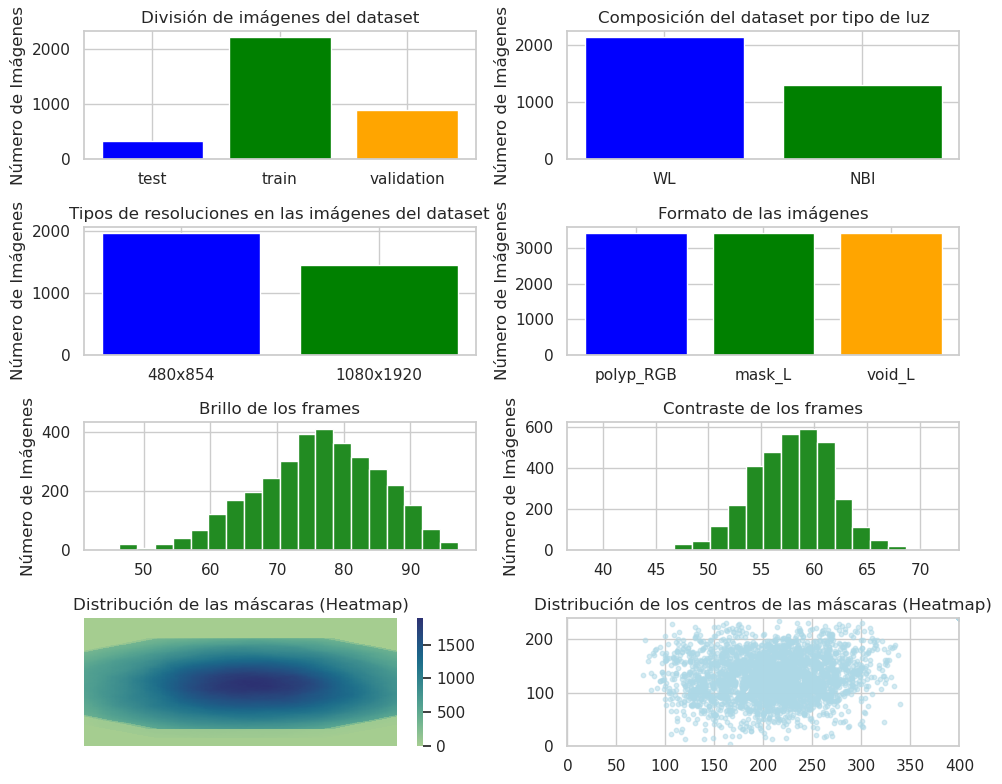

In [11]:
dt_Piccolo.graph_summmary()

Finalmente veamos una muestra de una imágen aleatoria y su aspecto con la bbox

Imagen 063_VP19_frame0036.png	bbox: (549, 317, 190, 162)


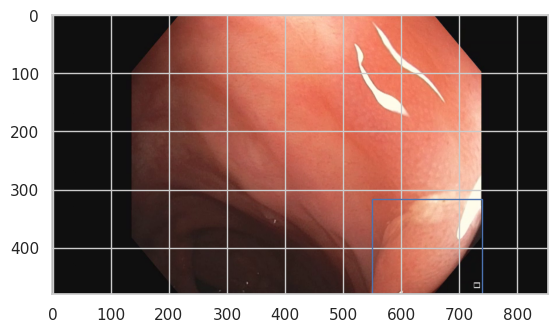

In [12]:
import random

# mostramos aleatoriamente una imágen del dataset
rand_key = random.choice(list(dt_Piccolo.dict.keys()))
dt_Piccolo.show_image(rand_key)

## Entrenamiento de YOLO

Para esta segunda entrenaremos el modelo de [yolos-base](https://huggingface.co/hustvl/yolos-base)
con las imágenes del dataset de Piccolo, con la peculiaridad que trataremos con 
un modelo modificado para devolver solo las bboxes.

#### Pasos del entrenemiento
1. **Modificaremos el modelo** para entrenar y devolver tan solo las bboxes ya que 
YOLO tiene dos MLP de salida que recogen los mismos datos del encoder, estas
son las **dos salidas de yolo** que son el clasificador de clases de COCO y las
bbox que localizan este objeto, **solo nos interesa la segunda**

2. **Preparar todo para el entrenamiento**, esto son elementos como el 
optimizador y la función de pérdida además de juntar definitivamente los datos
en los splits adecuados y DataLoaders para usarlos en la función de entrenamiento

3. **Entrenar** el modelo y ir obteniendo datos del rendimiento del mismo para
poder mostrarlos más adelante

### Modificar el modelo para Fine-Tunning
Tenemos un modelo de **yolos-base** con una arquitectura ViT y la salida del decoder
se da a dos MLP aisladas, estas son las dos salidas:

1. MLP de dos capas con una salida de claisificacion de 92 clases de COCO
2. MLP de dos capas pero la salida es un vector de 4 elementos con las coordenadas
en formato "center" o YOLO de la bbox **(cx,cy,w,h)**

En ambos casos el modelo de **Yolo hará 100 predicciones** de cajas y de clases.

Como queremos simplemente una prediccion de bbox, debemos hacer dos cosas
- Congelar la MLP correspondiente a la clasificacion de COCO ya que **solo queremos la obtención de las bboxes** con las que detectamos los pólipos.
- Reemplazara la capa de detección de bboxes por una que solo obtenga 1 prediccion
haciendo el modelo **más eficiente y sencillo**. Algo que puede ayudar debido a
la baja variabilidad de las imágenes de pólipos que son muy parecidas entre si.

Ya que estamos creando una nueva cabeza de predicción en para el modelo de yolos,
 congeelamos el modelo para **hacer un fine tunning de esta última capa** y ver que 
 tal funciona.

Para ello crearemos una clase con el modelo de Yolos personalizado como indica 
la [documentación de hugging face](https://huggingface.co/docs/transformers/custom_models).
y en ella personalizaremos las siguientes preferencias:
- **Eliminar class_labels_classifier**: Se borra y se reemplaza por None.
- El **forward() solo devuelve las bboxes**: Se quita la salida de clasificación.
- El modelo ahora **solo hace backpropagation en las bounding boxes**

In [13]:
import torch.nn as nn
import torch
from ultralytics.utils.ops import non_max_suppression


"""
    Vamos a modificar la salida de YOLOv8 para obtener uhna única salida con 
    una bbox ya que es lo que buscamos con nuestro modelo.
"""
class DetectionYOLOv8(nn.Module):
    def __init__(self, yolov8_model):
        super(DetectionYOLOv8, self).__init__()  # iniciamos la clase padre antes evitar errores
        self.model = yolov8_model

        # El modelo viene precongelado, hay que descongelarlo para el fine-tunning
        for param in self.model.parameters():
            param.requires_grad = True

    """
    Modificamos la salida de [batch_size, num_pred, 6] siendo la útlima dimension;
    (x_center, y_center, width, height, confidence, class_id) para tener simplemente
    la bbox en formato YOLO: (x_center, y_center, width, height)
    """
    def forward(self, x):
        # x es la entrada de la imagen
        inter_results = self.model(x)[0]  # obtenemos el tensor de predicciones intermedio
        bboxes = []

        # Usamos .view() para reestructurar
        # Convertimos de [B, 144, 80, 80] a [B, 144, num_preds]
        inter_results = inter_results.view(inter_results.shape[0], 144, -1)  

        # Para cada predicción, tomamos las 4 primeras columnas: (x_center, y_center, width, height) y las clases
        pred_bboxes = inter_results[..., :4]  # Coordenadas de la bbox
        confs = inter_results[..., 4:5]       # Confianza

        # Convertimos las predicciones a la forma [B, num_preds, 6]
        preds = torch.cat([pred_bboxes, confs], dim=-1)

        # obtenemos la confianza en las predicciones normalizada 
        weights = torch.softmax(confs, dim=1)

        # obtenemos la bbox media según la confianza en cada predicción
        weighted_bbox = (pred_bboxes * weights).sum(dim=1)

        return {'pred_bboxes': weighted_bbox}

#### Preparar el entrenamiento
Una vez modificado el modelo solo debemos preparar el entrenamiento, es decir:
- Definir los dataloders
- Cargar el modelo personaliazdo
- Definir las funciones de pérdida y optimizadores
- Definir una fuinciñon de entrenamiento

Utilizaremos el **optimizador Adalain** ya que es el usado en Yolos-base y la 
**loss fuction smooth_l1_loss** para las bbox de la salida ya que es información contínua

#### Funcion de entrenamiento

Ya que para utilizar imégenes el proceso es algo largo ya que hay que cargarlas,
 transformarlas y guardaralas en la GPU, independientemente de si es para train
 validation o test.
 
 Vamos a crear una **función** para poder **pasar las imágenes por el modelo**
 independientemente de si es para entrenar, validar o test y así evitamos repetir código


#### Entrenamiento

Ahora por fin pasamos a entrenar el modelo y recopilar los dátos de análisis 
para ellos obtenemos el IoU de las bboxes, ya que al ser areas en al imágen no 
podemos medir un "accuracy" tal cual.

**IoU** es una métrica usada para este
tipo de situaciones en las que se calcula: **IoU=Area_interseccion/Area_union** 
por lo que es importante tener en cuenta que **un IoU 1 es una coincidencia exacta**

In [14]:
import torch
from ultralytics import YOLO

model = DetectionYOLOv8(YOLO('yolov8n.pt').model)
model.train()

DetectionYOLOv8(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, trac

In [15]:
from utils import TrainModel as trm
from torch.optim import AdamW
import json

# definimos los parametros del entrenamiento 🏃‍♂
MODEL_NAME = "YOLOv8"
NUM_EPOCH = 60              # 🔄 Numero de epocas del entrenamiento 
BATCH_SIZE = 10             # 👝 Numero de imágenes por batch
TRAIN_RES = (640, 640)      # 📷 Resolucion entreno, respetamos la proporción 16/9
RESULTS_JSON = f"./resultados/Piccolo_{MODEL_NAME}_{NUM_EPOCH}EP_{TRAIN_RES[0]}x{TRAIN_RES[1]}.json"
RESULTS_IMG = f"./resultados/Piccolo_{MODEL_NAME}_{NUM_EPOCH}EP_{TRAIN_RES[0]}x{TRAIN_RES[1]}.png"
json_exists = False

# Obtener los diccionarios con formato de entrenamiento
train_loader, val_loader, test_loader = dt_Piccolo.get_dataloaders(
                                            BATCH_SIZE, use_premade_splits=True)

# definimos el optimizador y la loss function
def loss_fn(target, pred):
    return nn.functional.smooth_l1_loss(pred, target)

optimizer = AdamW(model.parameters(), lr=5e-5)
trainer = trm(model, loss_fn=loss_fn, optim=optimizer)

# si ya tenemos los resulados no volvemos a entrenar
if os.path.isfile(RESULTS_JSON):
    with open(RESULTS_JSON, "r", encoding="utf-8") as json_file:
            train_results = json.load(json_file)
    json_exists = True

if not json_exists:
    train_results = trainer.train_model(NUM_EPOCH, TRAIN_RES, 
                                    train_loader, val_loader, test_loader)

    # guardamos los datos
    with open(RESULTS_JSON, "w", encoding="utf-8") as json_file:
        json.dump(train_results, json_file)  # `indent=4` para formato legible

KeyboardInterrupt: 

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (3): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (4): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0-1): 2 x Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (5): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (6): C2f(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0-1): 2 x Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (7): Conv(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (8): C2f(
        (cv1): Conv(
          (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (9): SPPF(
        (cv1): Conv(
          (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
      )
      (10): Upsample(scale_factor=2.0, mode='nearest')
      (11): Concat()
      (12): C2f(
        (cv1): Conv(
          (conv): Conv2d(384, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (13): Upsample(scale_factor=2.0, mode='nearest')
      (14): Concat()
      (15): C2f(
        (cv1): Conv(
          (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (16): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (17): Concat()
      (18): C2f(
        (cv1): Conv(
          (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (19): Conv(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (20): Concat()
      (21): C2f(
        (cv1): Conv(
          (conv): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
          )
        )
      )
      (22): Detect(
        (cv2): ModuleList(
          (0): Sequential(
            (0): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (1): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          )
          (1): Sequential(
            (0): Conv(
              (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (1): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): Sequential(
            (0): Conv(
              (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (1): Conv(
              (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (cv3): ModuleList(
          (0): Sequential(
            (0): Conv(
              (conv): Conv2d(64, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (1): Conv(
              (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (2): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1))
          )
          (1): Sequential(
            (0): Conv(
              (conv): Conv2d(128, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (1): Conv(
              (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (2): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): Sequential(
            (0): Conv(
              (conv): Conv2d(256, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (1): Conv(
              (conv): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (2): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (dfl): DFL(
          (conv): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
      )
    )
  )
)

## Análisis de los resultados

Una vez entrenado el modelo y finalizada la obtencion de datos durante el entrenamiento,
además de disponer de los datos de test vamos a graficar los resultados y ver 
que tal ha ido el entrenamiento.

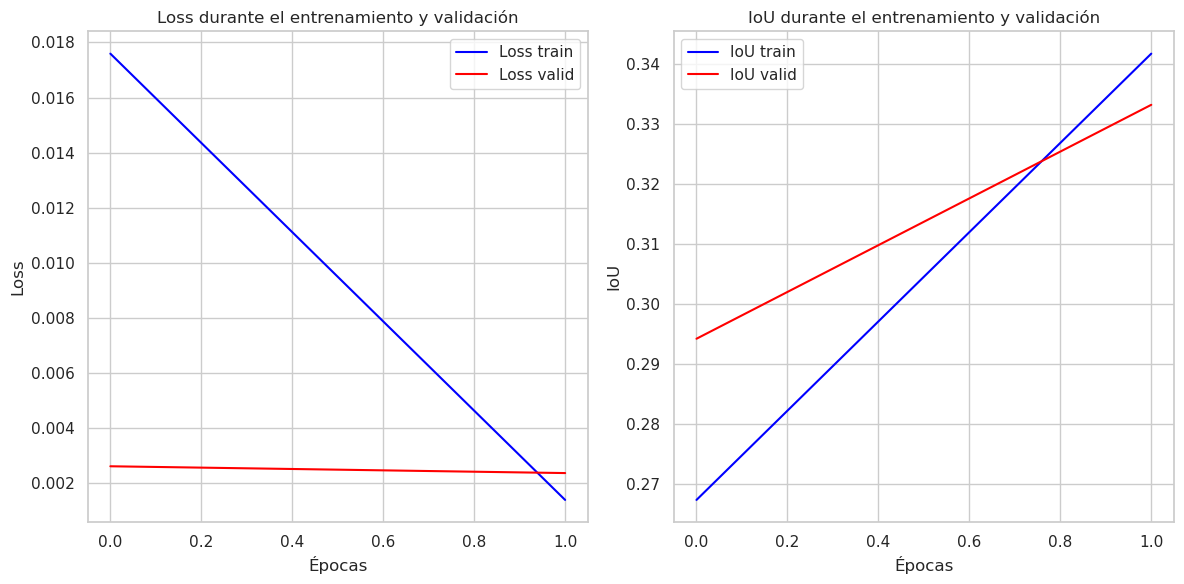

End of training!
-------------------- FINAL RESULTS ------------------------
|     - Test loss:     0.001893701596254232                         |
|     - Test IoU: 0.24137061631499981                         |
-----------------------------------------------------------


In [ ]:
trainer.show_results(train_results, save_img=True, img_name=RESULTS_IMG)